In [ ]:
#default_exp swav

# SwAV

> [Unsupervised Learning of Visual Features by Contrasting Cluster Assignments](https://arxiv.org/pdf/2006.09882.pdf)


In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Data Augmentation

We can use batch data augmentation utilities form `self_supervised.augmentations` module.

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

SimCLR augmentations side by side with the original image

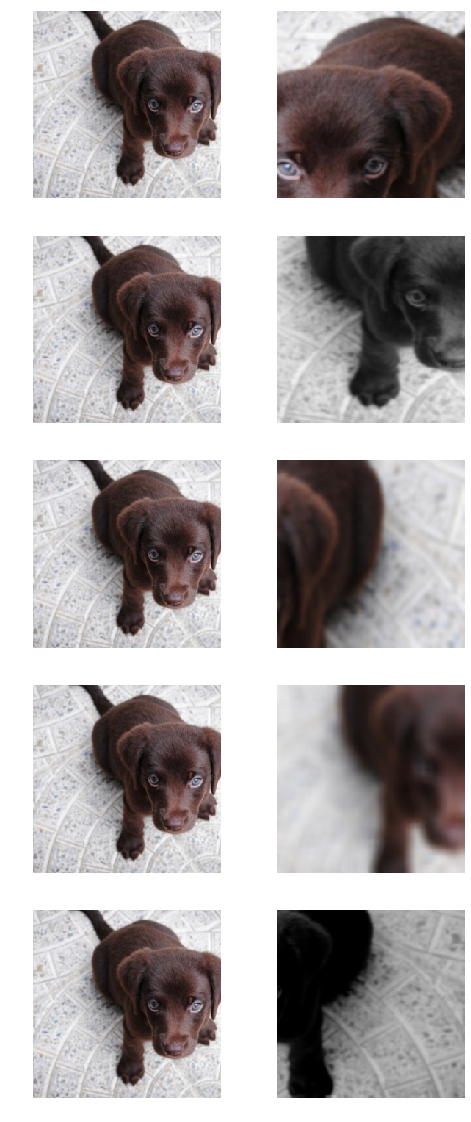

In [ ]:
aug = get_batch_augs(224, cuda=False)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/swav.png)

For encoder any PyTorch model which takes an image input and outputs embeddings/representations can be used. You can also use utilities to create encoder from the models defined in `fastai` or `timm` using the following functions: `create_fastai_encoder` and `create_timm_encoder`. Fastai expects a function such as `xresnet18` as first argument whereas timm expects a string like `"tf_efficientnet_b0_ns"`.

In [ ]:
timm_encoder = create_timm_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False)

In [ ]:
L(timm_encoder.named_children())[-4:].itemgot(1)

(#4) [BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),SiLU(inplace=True),SelectAdaptivePool2d (pool_type=catavgmax, flatten=True),Identity()]

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=3, pretrained=False)

In [ ]:
L(fastai_encoder.named_children())[-3:].itemgot(1)

(#3) [Sequential(
  (0): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idpath): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): ReLU(inplace=True)
  )
  (1): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

For creating MLP module aka projector `create_mlp_module` can be used.

This `MLP` module is same with the one implemented for BYOL

In [ ]:
#export
class SwAVModel(Module):
    "SwAV model"
    def __init__(self,encoder,projector,prototypes): 
        self.encoder,self.projector,self.prototypes = encoder,projector,prototypes
    
    def forward(self, inputs): 
        
        if not isinstance(inputs, list): inputs = [inputs]
            
        crop_idxs = torch.cumsum(torch.unique_consecutive(
                                torch.tensor([inp.shape[-1] for inp in inputs]),
                                return_counts=True)[1], 0)

        start_idx = 0
        for idx in crop_idxs:
            _z = self.encoder(torch.cat(inputs[start_idx: idx]))
            if not start_idx: z = _z
            else:             z = torch.cat((z, _z))
            start_idx = idx
        
        z = F.normalize(self.projector(z))
        return z, self.prototypes(z)

In [ ]:
#export
def create_swav_model(encoder, n_in=3, hidden_size=256, projection_size=128, n_protos=3000):
    "Create SwAV model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=True)
    prototypes = nn.Linear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

In [ ]:
model = create_swav_model(timm_encoder, n_in=3, hidden_size=2048, projection_size=128)
multi_view_inputs = ([torch.randn(2,3,224,224) for i in range(2)] +
                     [torch.randn(2,3,96,96) for i in range(4)])
embedding, output = model(multi_view_inputs)
norms = model.prototypes.weight.data.norm(dim=1)
assert norms.shape[0] == 3000
assert [n.item() for n in norms if test_close(n.item(), 1.)] == []

## SwAV Callback

In [ ]:
#export
def sinkhorn_knopp(Q, nmb_iters, device=default_device):
    "https://en.wikipedia.org/wiki/Sinkhorn%27s_theorem#Sinkhorn-Knopp_algorithm"
    with torch.no_grad():
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        r = (torch.ones(Q.shape[0]) / Q.shape[0]).to(device)
        c = (torch.ones(Q.shape[1]) / Q.shape[1]).to(device)

        curr_sum = torch.sum(Q, dim=1)

        for it in range(nmb_iters):
            u = curr_sum
            Q *= (r / u).unsqueeze(1)
            Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
            curr_sum = torch.sum(Q, dim=1)
        return (Q / torch.sum(Q, dim=0, keepdim=True)).t().float()

In [ ]:
# #export
# class SWAVLoss(Module):
#     "Multi crop loss"
#     def __init__(self): pass     
#     def forward(self,log_ps,qs):
# #         import pdb; pdb.set_trace()
#         loss = 0
#         for i in range(len(qs)):
#             l = 0
#             q = qs[i]
#             for p in (log_ps[:i] + log_ps[i+1:]):
#                 l -= torch.mean(torch.sum(q*p, dim=1))/(len(log_ps)-1)
#             loss += l/len(qs)
#         return loss

In [ ]:
#export
class SWAVLoss(Module): 
    def forward(self,log_ps,qs):
        loss = 0        
        t = (qs.unsqueeze(1)*log_ps.unsqueeze(0)).sum(-1).mean(-1)
        for i, ti in enumerate(t): loss-=(ti.sum() - ti[i])/(len(ti)-1)/len(t)
        return loss

In [ ]:
qs = torch.randn((2,16,128))
log_ps = torch.randn((8,16,128))

In [ ]:
loss_func = SWAVLoss()
loss_func(log_ps,qs)

tensor(0.5323)

This loss function calculates multi crop cross entropy loss between original views and low resolution views of the same image. Total `N(V+1)` comparisions are made for a given image, where `N` is the number of original views and `V` is the number of low resolution views

In [ ]:
#export
class SWAV(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_func=get_batch_augs,
                       crop_sizes=[224,96], 
                       num_crops=[2,6],
                       min_scales=[0.25,0.05],
                       max_scales=[1.,0.14],
                       crop_assgn_ids=[0,1],
                       eps=0.05,
                       n_sinkh_iter=3,
                       temp=0.1,
                       **aug_kwargs):
        
        store_attr('num_crops,crop_assgn_ids,temp,eps,n_sinkh_iter')
        self.augs = []
        for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
            self.augs += [aug_func(size, resize_scale=(mins, maxs), **aug_kwargs) for i in range(nc)]
        for aug in self.augs:print(aug)
    
    def before_batch(self):
        "Compute multi crop inputs"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)
        

    def after_pred(self):
        "Compute ps and qs"    
        embedding, output = self.pred
        with torch.no_grad():
            qs = []
            for i in self.crop_assgn_ids:
                # TODO: Store previous batch embeddings
                # to be used in Q calculation
                # Store approx num_proto//bs batches 
                # output.size(1)//self.bs
                target_b = output[self.bs*i:self.bs*(i+1)]
                q = torch.exp(target_b/self.eps).t()
                q = sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q)
        
        log_ps = []
        for v in np.arange(np.sum(self.num_crops)):
            log_p = F.log_softmax(output[self.bs*v:self.bs*(v+1)] / self.temp, dim=1)
            log_ps.append(log_p)
         
        log_ps = torch.stack(log_ps)
        qs = torch.stack(qs)
        self.learn.pred, self.learn.yb = log_ps, (qs,)
    
    
    def after_batch(self):
        with torch.no_grad():
            w = self.learn.model.prototypes.weight.data.clone()
            self.learn.model.prototypes.weight.data.copy_(F.normalize(w))
        
        
    def show_one(self):
        xb = self.learn.xb[0]
        i = np.random.choice(self.bs)
        images = [aug.decode(b.to('cpu').clone()).clamp(0.1)[i] 
                      for b, aug in zip(xb, self.augs)]
        show_images(images)

`crop_sizes` defines the size to be used for original crops and low resolution crops respectively. `num_crops` define `N`: number of original views and `V`: number of low resolution views respectively. `min_scales` and `max_scales` are used for original and low resolution views during random resized crop. `eps` is used during Sinkhorn-Knopp algorithm for calculating the codes and `n_sinkh_iter` is the number of iterations during it's calculation. `temp` is the temperature parameter in cross entropy loss

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=4, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_swav_model(fastai_encoder, n_in=1, hidden_size=2048, projection_size=128)
learn = Learner(dls, model, SWAVLoss(),
                cbs=[SWAV(crop_sizes=[28,16], min_scales=[0.25,0.05], max_scales=[1.0,0.3],
                          rotate=False, jitter=False, bw=False, blur=False,stats=None,cuda=False),
                     ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.pred = learn.model(*learn.xb)

Display 2 standard resolution crops and 6 additional low resolution crops, aka multi crop

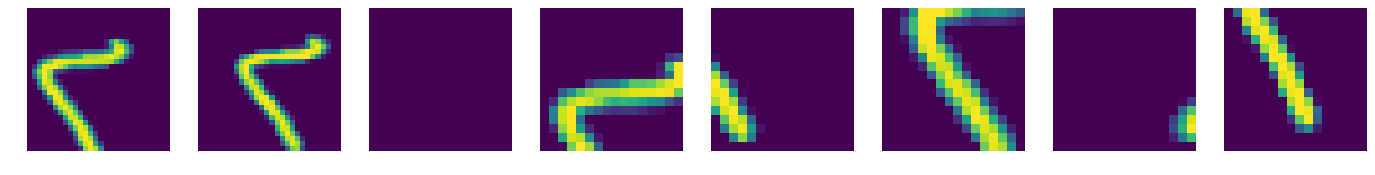

In [ ]:
learn.swav.show_one()

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(8.3689)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00-utils.ipynb.
Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
